### Complejidad - Práctico 2/6 - Movimiento de pájaros 
#### Lautaro Giordano

En este tp vamos a implementar el modelo de Vicsek y a tratar de darle una vuelta de tuerca más.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [106]:
# Tamaño del sistema: L x L
class bird:
    def __init__(self, x, y, angle, velocity):
        self.x = x
        self.y = y
        self.angle = angle
        self.velocity = velocity
        self.update_velocity()

    def move(self, dt):
        self.x += self.vx * dt
        self.y += self.vy * dt
    
    def distance(self, other):
        return np.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)
    
    def update_velocity(self):
        self.vx = self.velocity * np.cos(self.angle)
        self.vy = self.velocity * np.sin(self.angle)
        
    def __str__(self):
        return f'({self.x}, {self.y})'
    
class flock:
    def __init__(self, n, radius=.1, velocity=1, noise_level=0.1, L=5):
        self.birds = [bird(np.random.rand() * L,            # Posicion x inicial
                           np.random.rand() * L,            # Posicion y inicial
                           np.random.rand() * 2*np.pi,  # Angulo inicial
                           velocity) 
                        for _ in range(n)]

        self.n_birds = n
        # Radio de interaccion
        self.radius = radius
        self.velocity = velocity
        self.noise_level = noise_level
        self.L = L
        self.dt = 1
        # Sumo vectorialmente todas las velocidades y calculo el modulo de ese vector
        # Es el parametro de orden que usan en el modelo de Vicsek
        self.average_velocity = [self.update_average_velocity()]
    
    def move(self, dt):
        for b in self.birds:
            b.move(dt)
            # Condiciones de contorno periodicas
            b.x = b.x % self.L
            b.y = b.y % self.L
    
    def update_average_velocity(self):
        v_sum_x = np.sum([b.vx for b in self.birds])
        v_sum_y = np.sum([b.vy for b in self.birds])
        return np.sqrt(v_sum_x**2 + v_sum_y**2) / (self.velocity * self.n_birds)

    def distances(self):
        return np.array([[b.distance(other) for other in self.birds] for b in self.birds])
    
    def run_step(self):
        distances = self.distances()
        for i, bird in enumerate(self.birds):
            v_sum_x = 0
            v_sum_y = 0
            close_birds = 0
            # Para cada pajaro, calculo el promedio de los angulos de los pajaros que estan a una distancia menor al radio
            for j, distance in enumerate(distances[i]):
                if distance < self.radius:
                    v_sum_x += np.cos(self.birds[j].angle)
                    v_sum_y += np.sin(self.birds[j].angle)
                    close_birds += 1

                # Si hay pájaros cercanos, actualizo el ángulo basado en los promedios
            if close_birds > 0:
                mean_angle = np.arctan2(v_sum_y, v_sum_x)
                bird.angle = mean_angle + np.random.normal(0, self.noise_level)
                bird.update_velocity()
                
        # Ahora que todos los angulos y velocidades estan actualizados, muevo los pajaros y actualizo el parametro de orden
        self.move(self.dt)
        self.average_velocity.append(self.update_average_velocity())

    def run(self, steps):
        for _ in range(steps):
            self.run_step()

    def plot(self):
        x = [b.x for b in self.birds]
        y = [b.y for b in self.birds]
        # Ploteo las aves con una pequeña flecha indicando la direccion de 
        # su velocidad (todas del mismo tamaño)
        plt.quiver(x, y, [b.vx for b in self.birds], [b.vy for b in self.birds])
        
    
    # Gracias chatgpt
    def animate(self, steps, interval=100, save_as_gif=False):
        # Create a figure and axis
        fig, ax = plt.subplots()
        ax.set_xlim(0, L)
        ax.set_ylim(0, L)
        
        # Scatter plot of the birds' positions
        scatter = ax.quiver(
            [b.x for b in self.birds],
            [b.y for b in self.birds],
            [b.vx for b in self.birds],
            [b.vy for b in self.birds]
        )

        # Quito los ejes
        ax.axis('off')
        
        # Update function for the animation
        def update(frame):
            # Run a step of the simulation
            self.run_step()
            
            # Update the scatter plot with new positions and velocities
            scatter.set_offsets(np.c_[[b.x for b in self.birds], [b.y for b in self.birds]])
            scatter.set_UVC([b.vx for b in self.birds], [b.vy for b in self.birds])
            return scatter,

        # Create the animation
        anim = animation.FuncAnimation(
            fig, update, frames=steps, interval=interval, blit=False
        )

        # Save animation as a gif if required
        if save_as_gif:
            anim.save('flock_animation.gif', writer='imagemagick', fps=30)
        
        plt.show()
    

Voy a usar tamaño N=100 durante todo el tp, porque la complejidad de la simulación es O(n^2) y aumentar más el tamaño haría que la simulación pase de demorar segundos/minutos a horas.

Hagamos algunas animaciones para ver como se mueven las aves

Ver "flock_animation_r_chico.gif"

MovieWriter imagemagick unavailable; using Pillow instead.


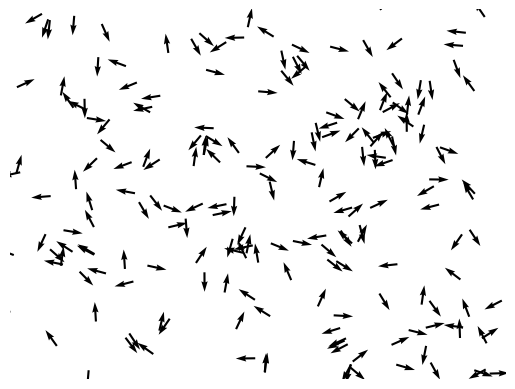

In [8]:
aves = flock(200, radius=.015, velocity=.04, noise_level=.1)
aves.animate(300, interval=300, save_as_gif=True)

Si aumento el radio, se ve la transicion de un comportamiento desordeanado a uno ordenado

Ver "flock_animation_r_grande.gif"

MovieWriter imagemagick unavailable; using Pillow instead.


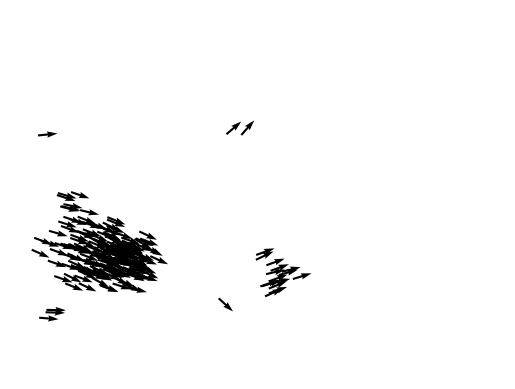

In [9]:
aves = flock(200, radius=.2, velocity=.04, noise_level=.05)
aves.animate(300, interval=300, save_as_gif=True)

Midamos la transicion de fase como hacen en el paper. Estudiemos como cambia la velocidad promedio final de los pajaros en funcion del radio, del ruido y la densidad.

Primero veamos si funciona el calculo de la velocidad promedio final en funcion del radio.

Velocidad promedio ultimos 50 pasos: 0.80


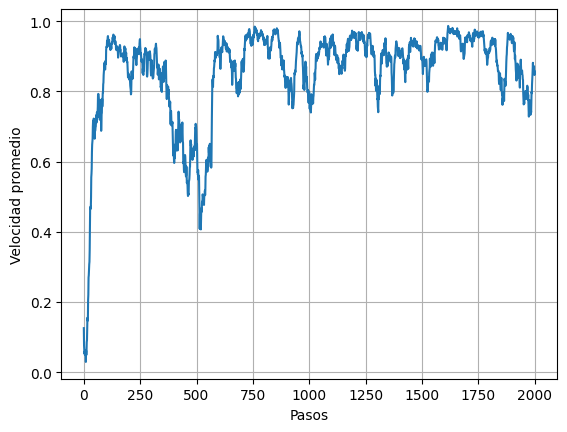

In [83]:
# Le pongo poco ruido
aves = flock(100, radius=.5, velocity=.04, noise_level=0.2)
aves.run(2000)
print(f"Velocidad promedio ultimos 50 pasos: {np.mean(aves.average_velocity[-50:]):.2f}")
plt.plot(aves.average_velocity)
plt.xlabel('Pasos')
plt.ylabel('Velocidad promedio')
plt.grid()

Corramos esto para muchos radios y hacemos un grafico de los promedios finales.

In [102]:
radios = np.linspace(0.0005, 1, 30)
velocidades_promedio = []
for i, r in enumerate(radios):
    print(f'Corriendo radios, paso {i+1} de {len(radios)}', end='\r')
    aves = flock(100, radius=r, velocity=.04, noise_level=0.2)
    aves.run(3000)
    velocidades_promedio.append(np.mean(aves.average_velocity[-50:]))

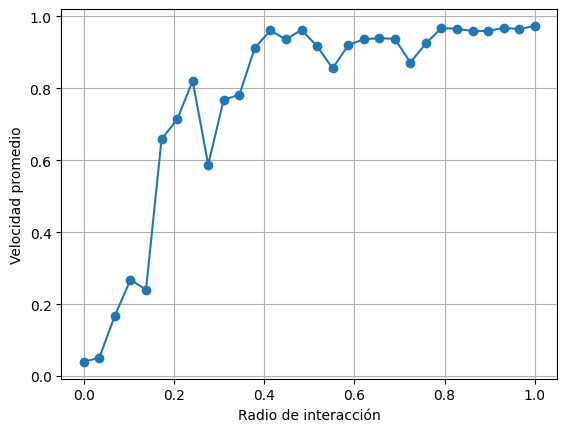

In [104]:
plt.plot(radios, velocidades_promedio, marker='o')
plt.xlabel('Radio de interacción')
plt.ylabel('Velocidad promedio')
plt.grid()

Ahora en funcion del ruido

Velocidad promedio ultimos 50 pasos: 0.9188915169889852


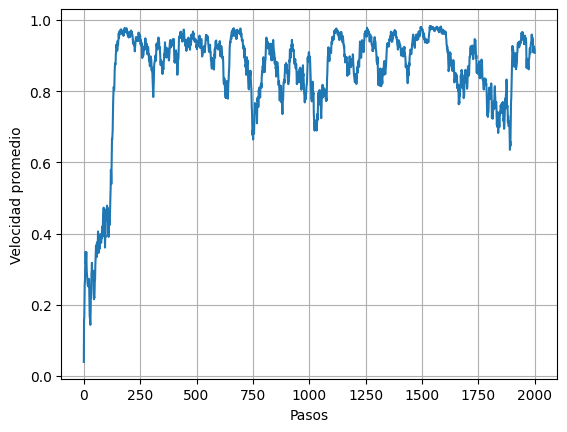

In [95]:
aves = flock(100, radius=.5, velocity=.04, noise_level=0.2)
aves.run(2000)
print(f"Velocidad promedio ultimos 50 pasos: {np.mean(aves.average_velocity[-50:])}")
plt.plot(aves.average_velocity)
plt.xlabel('Pasos')
plt.ylabel('Velocidad promedio')
plt.grid()

In [100]:
ruidos = np.linspace(0.01, 0.5, 30)
velocidades_promedio = []
for i, noise in enumerate(ruidos):
    print(f'Corriendo ruidos, paso {i+1} de {len(ruidos)}', end='\r')
    aves = flock(100, radius=.1, velocity=.04, noise_level=noise)
    aves.run(3000)
    velocidades_promedio.append(np.mean(aves.average_velocity[-50:]))

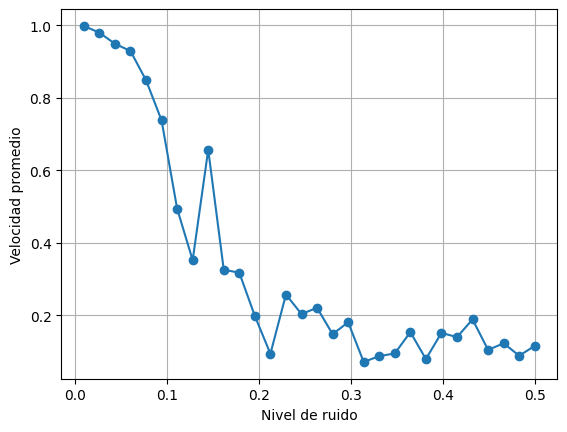

In [101]:
plt.plot(ruidos, velocidades_promedio, marker='o')
plt.xlabel('Nivel de ruido')
plt.ylabel('Velocidad promedio')
plt.grid()

Y en función de la densidad. (Voy a seguir usando N=100 y a cambiar L, quizás N es muy chico pero lo dejo fijo por una cuestión computacional)

In [152]:
densities = np.linspace(.5, 30, 30)
Ls = np.sqrt(100 / densities)
velocidades_promedio = []
for i, L in enumerate(Ls):
    print(f'Corriendo densidades, paso {i+1} de {len(Ls)}', end='\r')
    aves = flock(100, radius=.1, velocity=.04, noise_level=0.1, L=L)
    aves.run(3000)
    velocidades_promedio.append(np.mean(aves.average_velocity[-50:]))

KeyboardInterrupt: 

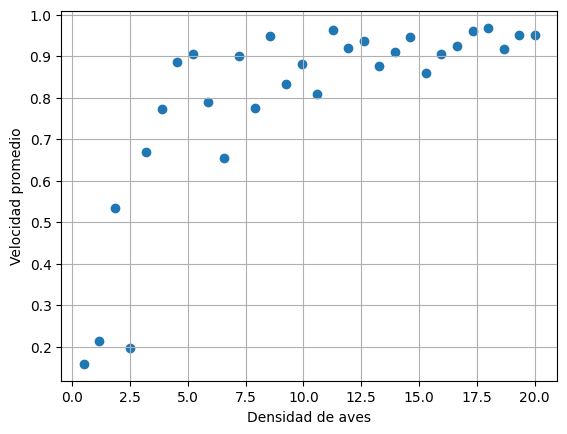

In [151]:
plt.scatter(densities, velocidades_promedio)
plt.xlabel('Densidad de aves')
plt.ylabel('Velocidad promedio')
plt.grid()

Acá viene la vuelta de tuerca: Y si pensamos a los pájaros como nodos de un grafo? Si dos pájaros se ven (distancia < r), entonces están conectados. El grafo va a ser dinámico porque los nodos se mueven. Podemos estudiar propiedades como la conectividad del grafo o el clustering y ver si funciona también como parámetro de orden para medir la transición.

Lo que sigue a continuación es una clase que usa la clase anterior de flock y agrega la funcionalidad de crear y actualizar un grafo y medir sus propiedades (para esto vamos a usar la librería Networkx).

In [28]:
import networkx as nx

In [54]:
class vicsek_graph(flock):
    def __init__(self, n, radius=0.1, velocity=1, noise_level=0.1, L=5):
        super().__init__(n, radius, velocity, noise_level, L)
        # El grafo va a ser de tipo networkx graph
        self.graph = None
        # Propiedades del grafo como listas
        self.mean_degree = []
        self.clustering = []
        self.giant_component = []
        self.build_graph()
        self.update_properties()

    def build_graph(self):
        # Funcion que crea el grafo de networkx (también se usa a cada paso para actualizarlo)
        edges = []
        distances = self.distances()
        for i, bird in enumerate(self.birds):
            for j, distance in enumerate(distances[i]):
                if distance < self.radius and i != j:
                    edges.append((i, j))
        self.graph = nx.Graph()
        self.graph.add_nodes_from(range(self.n_birds))
        self.graph.add_edges_from(edges)

    def update_properties(self):
        # Calcula las propiedades del grafo y las guarda en las listas
        self.mean_degree.append(np.mean(list(dict(self.graph.degree()).values())))
        self.clustering.append(networkx.average_clustering(self.graph))
        self.giant_component.append(len(max(networkx.connected_components(self.graph), key=len)) / self.n_birds)

    def run_step(self):
        # Corre un paso del modelo de Vicsek y luego actualiza el grafo y sus propiedades
        super().run_step()
        self.build_graph()
        self.update_properties()

    def run(self, steps):
        # Corre el modelo de Vicsek por una cantidad de pasos
        for _ in range(steps):
            self.run_step()

    def plot_graph(self):
        # Plotea el grafo
        nx.draw(self.graph, pos={i: (b.x, b.y) for i, b in enumerate(self.birds)}, node_size=20)

In [55]:
graph_model = vicsek_graph(100, radius=.3, velocity=0.04, noise_level=0.01)

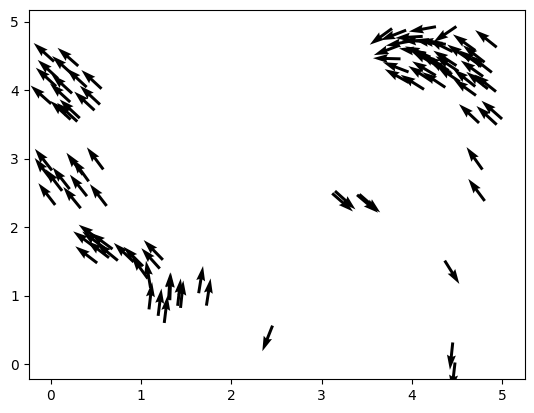

In [57]:
graph_model.plot()
for _ in range(500):
    graph_model.run_step()

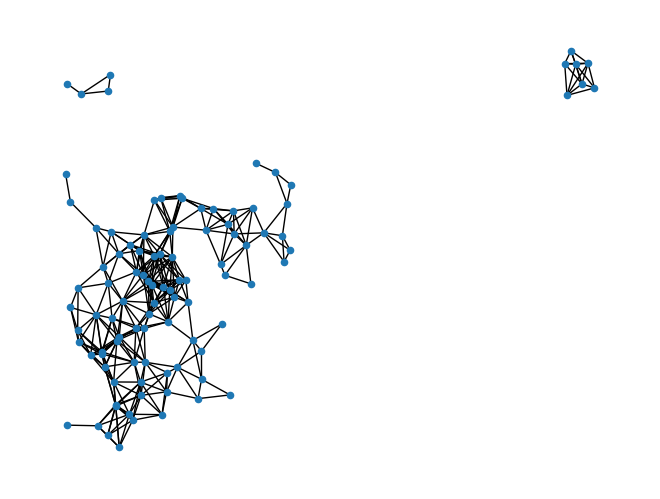

In [58]:
graph_model.plot_graph()

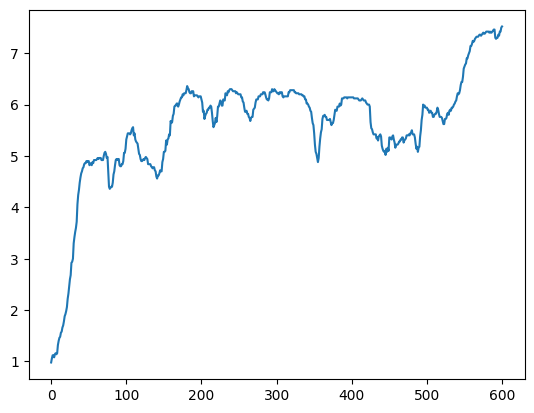

In [59]:
plt.plot(graph_model.mean_degree, label='Mean degree')

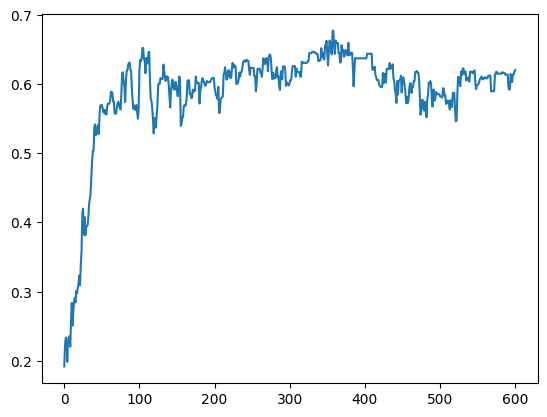

In [60]:
plt.plot(graph_model.clustering, label='Clustering')

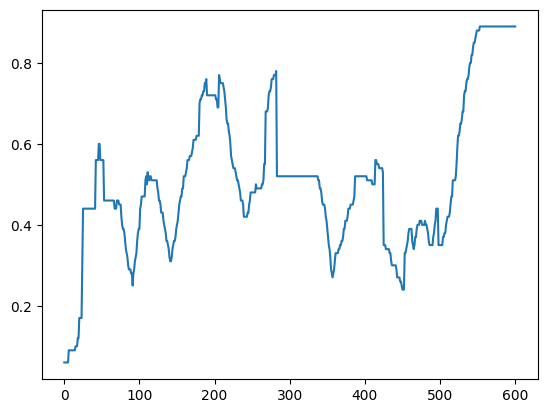

In [62]:
plt.plot(graph_model.giant_component, label='Giant component')

Veamos como se modifican el grado medio y clustering finales en función del radio y del ruido.

In [64]:
radios = np.linspace(0.0005, 0.05, 30)
mean_degrees = []
clustering = []
giant_components = []

for r in radios:
    graph_model = vicsek_graph(100, radius=r, velocity=0.04, noise_level=0.01)
    graph_model.run(500)
    mean_degrees.append(np.mean(graph_model.mean_degree[-50:]))
    clustering.append(np.mean(graph_model.clustering[-50:]))
    giant_components.append(np.mean(graph_model.giant_component[-50:]))

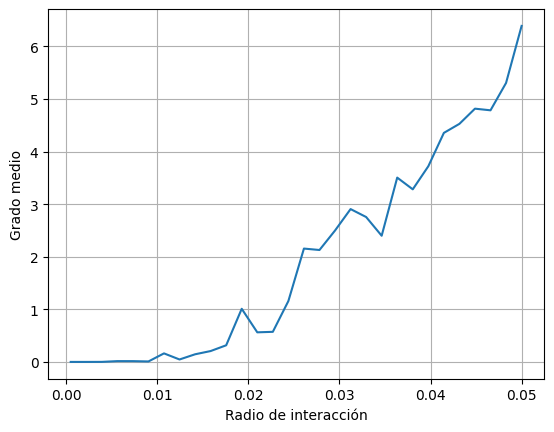

In [71]:
plt.plot(radios, mean_degrees, label='Mean degree')
plt.xlabel('Radio de interacción')
plt.ylabel('Grado medio')
plt.grid()

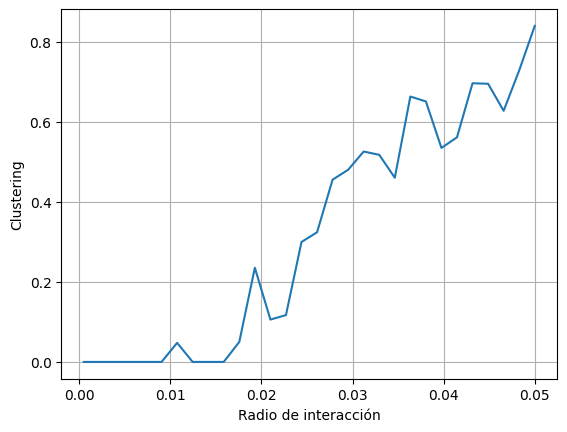

In [70]:
plt.plot(radios, clustering, label='Clustering')
plt.xlabel('Radio de interacción')
plt.ylabel('Clustering')
plt.grid()

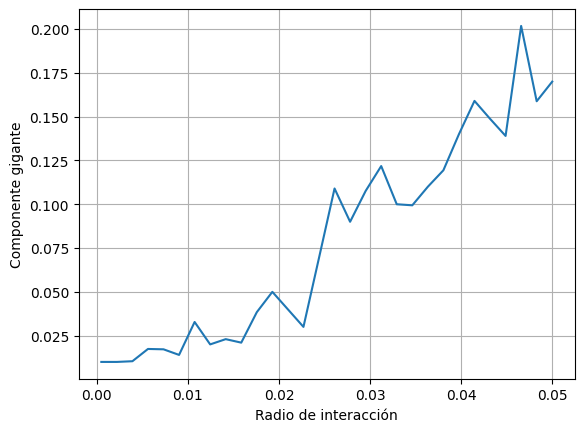

In [69]:
plt.plot(radios, giant_components, label='Giant component')
plt.xlabel('Radio de interacción')
plt.ylabel('Componente gigante')
plt.grid()